Data Processing

In [63]:
import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn import preprocessing

In [64]:
path = 'Assignment_1_data.csv'
df = pd.read_csv(path, header=0)
df.replace({'M': 0, 'F': 1, False:0.0, True:1.0}, inplace=True)
source_data = pd.DataFrame(df)
source_data['gender'] = source_data['gender'].astype('float64')
source_data['charlson_comorbidity_index'] = source_data['charlson_comorbidity_index'].astype('float64')
source_data['outcome'] = source_data['outcome'].astype('float64')
source_data = pd.DataFrame(df,columns=['gender','age','heart_rate_min','heart_rate_mean','heart_rate_max','mbp_min','mbp_max','mbp_mean','dbp_min','dbp_mean','dbp_max',"sbp_min",'sbp_max', 'sbp_mean', 'temperature_min','temperature_max','temperature_mean', 'glucose_min','glucose_max','wbc_min', 'wbc_max', 'creatinine_min','creatinine_max','urineoutput','hemoglobin_min','hemoglobin_max','pt_min','pt_max','sofa_coagulation','sofa_cardiovascular','sofa_cns','sofa_renal','charlson_comorbidity_index','outcome'])
source_data.dropna(inplace=True)
print(source_data)

       gender        age  heart_rate_min  heart_rate_mean  heart_rate_max  \
0         0.0  54.550390            93.0       103.500000           115.0   
1         0.0  86.324653            50.0        54.333333            61.0   
2         0.0  40.270146            70.0        83.434783           105.0   
4         0.0  70.724748            77.0        85.771429            95.0   
6         0.0  68.308897            60.0        71.083333            80.0   
...       ...        ...             ...              ...             ...   
36483     0.0  73.196221            70.0        70.600000            73.0   
36484     1.0  84.952721            59.0        68.538462            80.0   
36485     1.0  30.583263            59.0        79.954545           104.0   
36486     1.0  60.095765            71.0        82.625000            94.0   
36487     0.0  78.847051            63.0        72.836735            86.0   

       mbp_min  mbp_max    mbp_mean  dbp_min   dbp_mean  ...  hemoglobin_mi

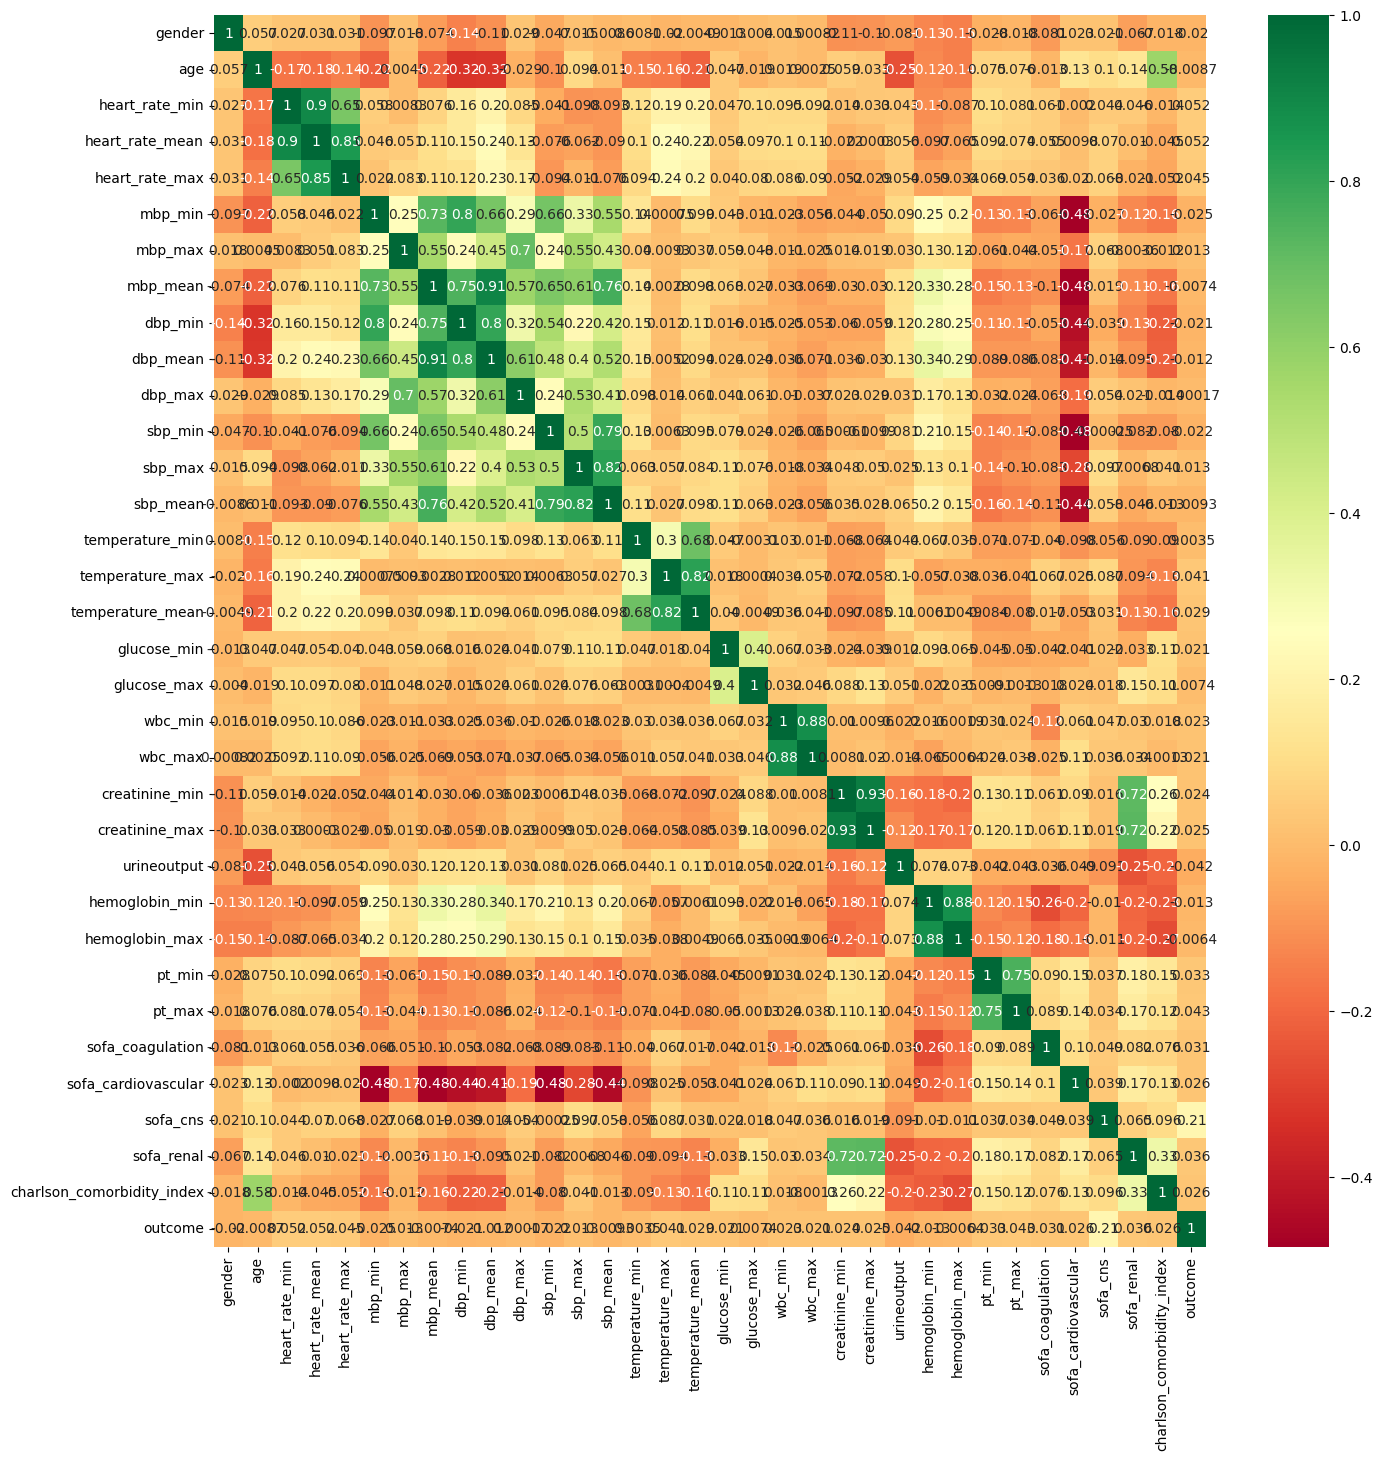

In [65]:
# Conduct Correlation Clustering
import matplotlib.pyplot as plt
corrmat = source_data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(16,16))
#plot heat map
g=sns.heatmap(source_data[top_corr_features].corr(),annot=True,cmap="RdYlGn")
plt.show()

In [66]:
# Make adjustments to four selected features based on the correlation clustering
source_data['wbc_mean'] = source_data[['wbc_min', 'wbc_max']].mean(axis=1)
source_data['hemoglobin_mean'] = source_data[['hemoglobin_min','hemoglobin_max']].mean(axis=1)
source_data['pt_mean'] = source_data[['pt_min','pt_max']].mean(axis=1)
source_data['creatinine_mean'] = source_data[['creatinine_min','creatinine_max']].mean(axis=1)

# See high correlation between sbp_mean, mbp_mean, and dbp_mean
# Drop two of them
source_data.drop(['dbp_mean','sbp_mean'], axis=1, inplace=True)

In [67]:
# Call the dataset
x_all_ud = source_data[['gender','age','heart_rate_mean','mbp_mean','temperature_mean','wbc_mean', 'glucose_min','glucose_max','creatinine_mean','urineoutput','hemoglobin_mean','pt_mean','sofa_coagulation','sofa_cardiovascular','sofa_cns','sofa_renal','charlson_comorbidity_index']].to_numpy()
preprocessing.Normalizer(copy=False).fit_transform(x_all_ud)
y_all = source_data['outcome'].to_numpy()
ar,num=np.unique(y_all,return_counts=True)
print(ar,num)

[0. 1.] [29412  1205]


In [68]:
# Perform the stepwise_forward method
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
def stepwise_forward(X, y, criterion, max_features=None):
    selected_features = []
    remaining_features = list(range(X.shape[1]))
    if max_features is None:
        max_features = X.shape[1]

    while remaining_features and len(selected_features) < max_features:
        best_feature = None
        best_score = -float('inf')
        for feature in remaining_features:
            candidate_features = selected_features + [feature]
            X_train = X[:, candidate_features]
            model = LinearRegression().fit(X_train, y)
            score = criterion(X,y)
            if criterion == 'f_regression':
                score = criterion(X_train, y)
            else:
                score = model.score(X_train, y)
            if score > best_score:
                best_score = score
                best_feature = feature
        remaining_features.remove(best_feature)
        selected_features.append(best_feature)
    return selected_features

In [69]:
print('The feature ranking is: ', stepwise_forward(x_all_ud, y_all,f_regression,max_features=11))
print('The F-value and P-value for each feature are: ', f_regression(x_all_ud, y_all))

The feature ranking is:  [14, 1, 2, 3, 6, 9, 8, 0, 7, 11, 15]
The F-value and P-value for each feature are:  (array([  4.38294326,  32.25806994,  91.8803359 ,  43.60126394,
        54.81366244,  54.83710892,  66.08134277,  60.33893841,
        39.88742223,  22.06999251,  41.79959307,  91.36365594,
        78.52248263,  90.76810293, 769.89512435,  36.47464064,
        56.98708849]), array([3.63084689e-002, 1.36217238e-008, 9.87846204e-022, 4.09159561e-011,
       1.35924412e-013, 1.34315347e-013, 4.48857192e-016, 8.23389336e-015,
       2.72720664e-010, 2.64028051e-006, 1.02645572e-010, 1.28157999e-021,
       8.32759963e-019, 1.73009984e-021, 2.24108569e-167, 1.56445623e-009,
       4.50872686e-014]))


Train-Test Split

In [70]:
# Based on the stepwise forward selection result, selected columns include 'sofa_cns', 'age', 'heart_rate_mean', 'mbp_mean', 'urineoutput', 'creatinine_mean', 'pt_mean', 'sofa_renal', 'sofa_coagulation', 'wbc_mean','charlson_comorbidity_index'
# Get new x_all
x_all = source_data[['sofa_cns', 'age', 'heart_rate_mean', 'mbp_mean', 'urineoutput', 'creatinine_mean', 'pt_mean', 'sofa_renal', 'sofa_coagulation', 'wbc_mean','charlson_comorbidity_index']].to_numpy()
from sklearn.model_selection import train_test_split
x, x_test, y, y_test = train_test_split(x_all,y_all,test_size=0.33,random_state=10)

Decision Tree Model

In [ ]:
# Use grid search to perform hyperparameter selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeClassifier()
params = {
    'criterion': ['entropy'],
    'max_depth': [ 5, 10, 20, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'random_state' : [10, 20, 30]
}

grid_search = GridSearchCV(dt, params, cv=5)
grid_search.fit(x, y)


print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

In [71]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Build the tree
TreeClassifier = DecisionTreeClassifier(criterion="entropy", max_depth=5, min_samples_leaf=2, min_samples_split= 2, random_state= 20)
clf_tree = TreeClassifier.fit(x,y)

# Test the performance of the model
y_test_tree = clf_tree.predict(x_test)
ar,num=np.unique(y_test_tree,return_counts=True)
print(ar,num)
print("The accuracy score for this model is ", (y_test==y_test_tree).sum()/len(y_test))

[0. 1.] [10092    12]
The accuracy score for this model is  0.9612034837688044


In [72]:
# Plotting ROC curve for the decision tree model
from sklearn.metrics import roc_curve, roc_auc_score
y_score_tree = clf_tree.predict_proba(x_test)[:,1]
print(y_score_tree.shape)
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score_tree)
roc_tree = roc_auc_score(y_test, y_score_tree)
print('roc_auc_score for decision tree: ', roc_tree)

(10104,)
roc_auc_score for decision tree:  0.7594621561267639


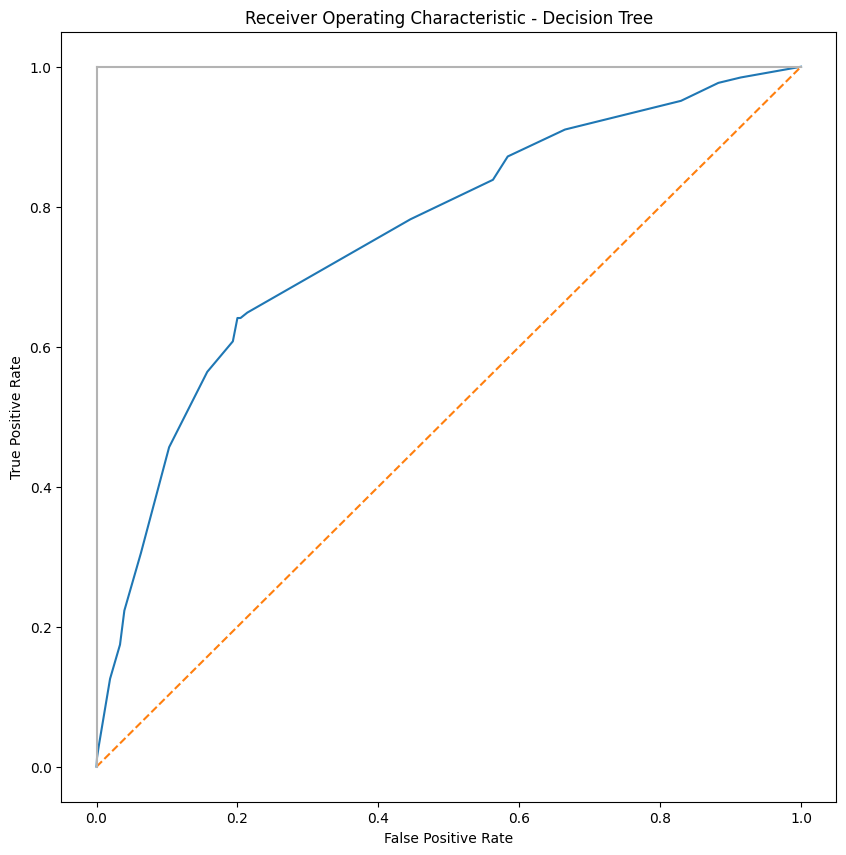

In [73]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Decision Tree')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Random Forest Model

In [ ]:
# Perform grid search to search for ideal hyperparameter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the random forest model
rf = RandomForestClassifier()

# Define the hyperparameters to be tuned
params = {
    'n_estimators': [3,5,10],
    'criterion': ['entropy'],
    'max_depth': [5, 10,  None],
    'min_samples_split': [2, 5, 8],
    'min_samples_leaf': [1, 2, 3],
    'n_jobs' : [-1,-2,-3]
}

# Perform a grid search with cross-validation
grid_search = GridSearchCV(rf, params, cv=5)
grid_search.fit(x, y)

# Print the best hyperparameters and score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)


In [74]:
# Build the model
from sklearn.ensemble import RandomForestClassifier
ForestClassifier = RandomForestClassifier(
    n_estimators=4,
    n_jobs=-2,
    min_samples_leaf= 3,
    min_samples_split= 8,
    max_depth= None,
    criterion='entropy'
)
rfc = ForestClassifier.fit(x,y)

In [75]:
# Test the performance of the model
y_test_rfc = rfc.predict(x_test)
ar,num=np.unique(y_test_rfc,return_counts=True)
print(ar,num)
print("The accuracy score for this model is ", (y_test==y_test_rfc).sum()/len(y_test))

[0. 1.] [10073    31]
The accuracy score for this model is  0.959916864608076


In [76]:
# Plotting ROC curve for the random forest model
from sklearn.metrics import roc_curve, roc_auc_score
y_score_rfc = rfc.predict_proba(x_test)[:,1]
print(y_score_rfc.shape)
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score_rfc)
roc_rfc = roc_auc_score(y_test, y_score_rfc)
print('roc_auc_score for random forest: ', roc_rfc)

(10104,)
roc_auc_score for random forest:  0.6556064997386801


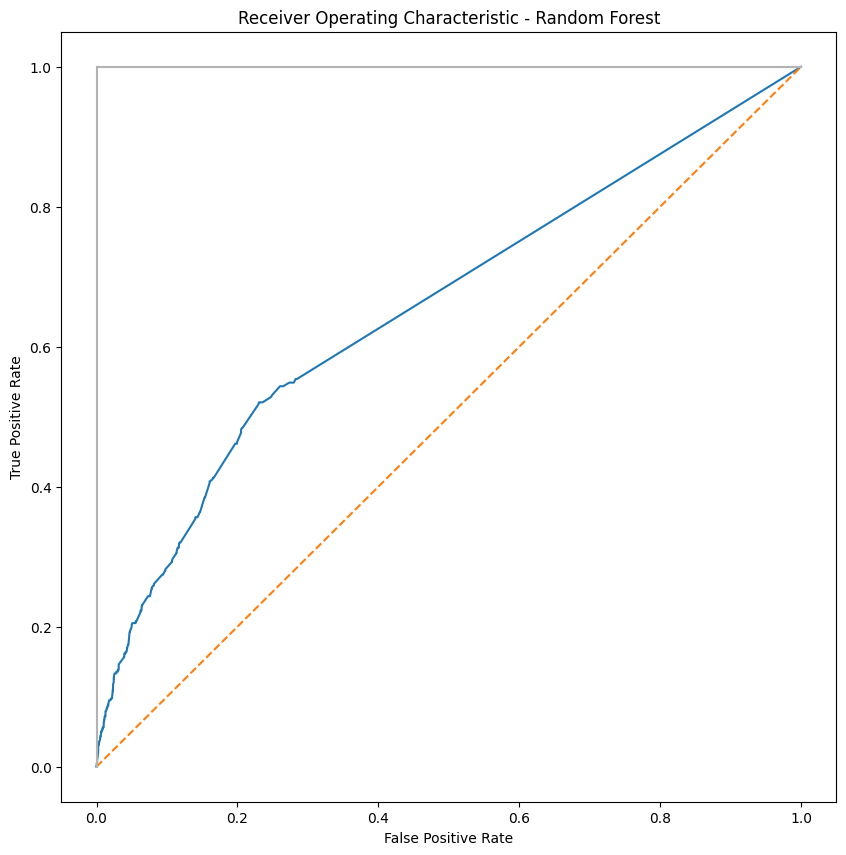

In [77]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

AdaBoost

In [ ]:
# Perform grid search for hyperparameter selection
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

# Define the AdaBoost model
ab = AdaBoostClassifier()

# Define the hyperparameters to be tuned
params = {
    'n_estimators': [30, 50, 100],
    'learning_rate': [0.01, 0.1, 1.0],
    'random_state' : [10, 20, 30]
}

# Perform a grid search with cross-validation
grid_search = GridSearchCV(ab, params, cv=5)
grid_search.fit(x, y)

# Print the best hyperparameters and score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

In [78]:
from sklearn.ensemble import AdaBoostClassifier

BoostClassifier = AdaBoostClassifier(n_estimators=50)
ada = BoostClassifier.fit(x,y)
# Test the performance of the model

y_test_ada = ada.predict(x_test)
ar,num=np.unique(y_test_ada,return_counts=True)
print(ar,num)
print("The accuracy score for this model is ", (y_test==y_test_ada).sum()/len(y_test))

[0. 1.] [10102     2]
The accuracy score for this model is  0.9615993665874901


In [79]:
# Plotting ROC curve for the Adaboost model
from sklearn.metrics import roc_curve, roc_auc_score
y_score_ada = ada.predict_proba(x_test)[:,1]
print(y_score_ada.shape)
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score_ada)
roc_ada = roc_auc_score(y_test, y_score_ada)
print('roc_auc_score for AdaBoost: ', roc_ada)


(10104,)
roc_auc_score for AdaBoost:  0.7609408572348659


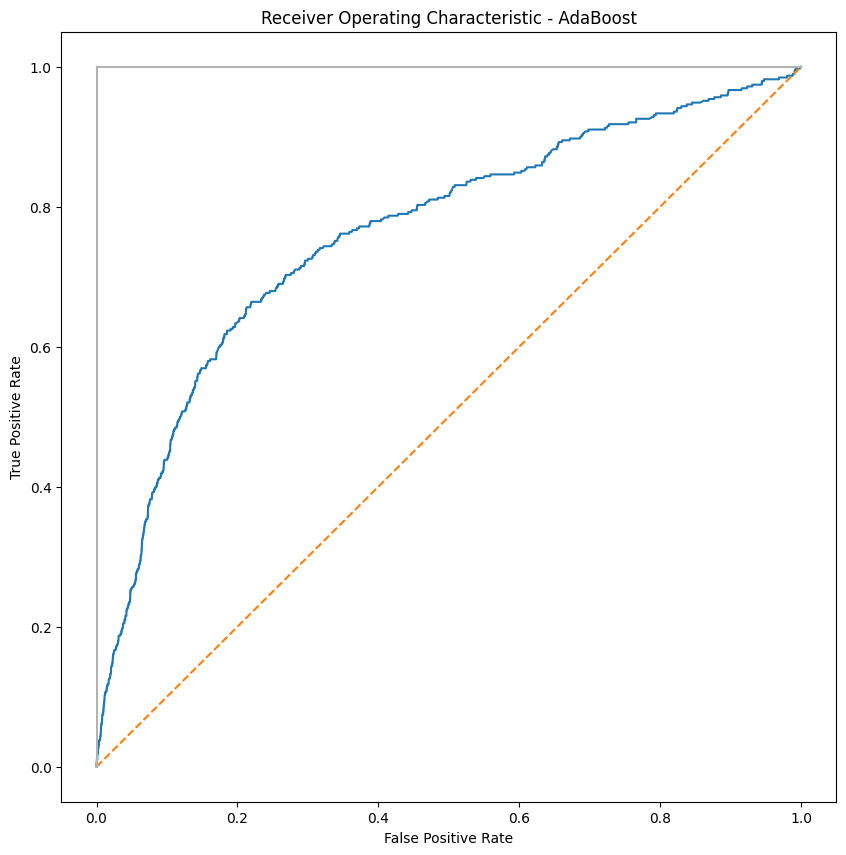

In [80]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - AdaBoost')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

SVM

In [ ]:
# Perform grid search for hyperparameter selection
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the SVM model
svm = SVC()

# Define the hyperparameters to be tuned
params = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf'],
    'degree': [2, 3, 4],
    'gamma': ['scale'],
    'random_state': [10, 20, 30]
}

# Perform a grid search with cross-validation
grid_search = GridSearchCV(svm, params, cv=5)
grid_search.fit(x, y)

# Print the best hyperparameters and score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

In [81]:
from sklearn.svm import SVC
clf_svm = SVC(C=2.0,kernel = 'rbf',
            gamma = 'scale', 
            probability=True, 
            class_weight='balanced'
            )
clf_svm.fit(x,y)

# Test the performance of the model
y_test_svm = clf_svm.predict(x_test)
ar,num=np.unique(y_test_svm,return_counts=True)
print(ar,num)
print("The accuracy score for this model is ", (y_test==y_test_svm).sum()/len(y_test))

[0. 1.] [5792 4312]
The accuracy score for this model is  0.5756136183689627


(10104,)
roc_auc_score for SVM:  0.5867439540076971


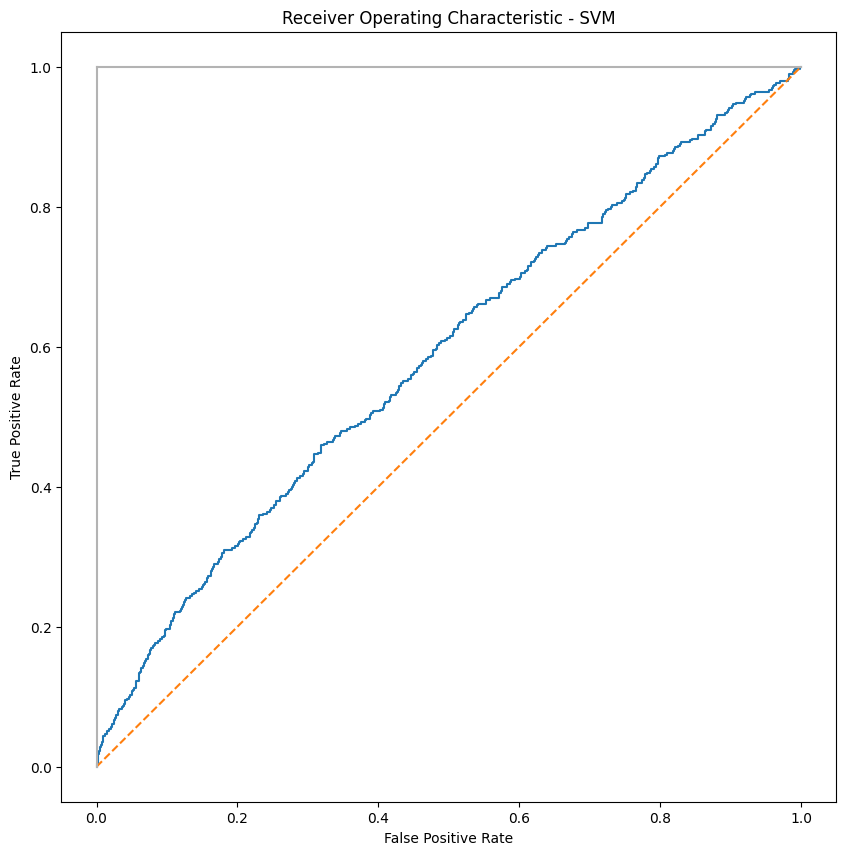

In [82]:
# Plotting ROC curve for the SVM model
from sklearn.metrics import roc_curve, roc_auc_score
y_score_svm = clf_svm.predict_proba(x_test)[:,1]
print(y_score_svm.shape)
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score_svm)
roc_svm = roc_auc_score(y_test, y_score_svm)
print('roc_auc_score for SVM: ', roc_svm)
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - SVM')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Logistic regression with L1 penalty

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the logistic regression model
lr = LogisticRegression(penalty='l1', solver='saga')

# Define the hyperparameters to be tuned
params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter' : [200, 500, 800],
    'random_state': [10, 20, 30],
}

# Perform a grid search with cross-validation
grid_search = GridSearchCV(lr, params, cv=5)
grid_search.fit(x, y)

# Print the best hyperparameters and score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

In [83]:
# Build the model
from sklearn.linear_model import LogisticRegression
clf_L1 = LogisticRegression(C=15.0,
                          penalty='l1',
                          solver='liblinear',
                          max_iter=500,
                          class_weight='balanced'
                          ).fit(x, y)

# Test the performance of the model
y_test_L1 = clf_L1.predict(x_test)
ar,num=np.unique(y_test_L1,return_counts=True)
print(ar,num)
print("The accuracy score for this model is ", (y_test==y_test_L1).sum()/len(y_test))

[0. 1.] [7617 2487]
The accuracy score for this model is  0.7663301662707839


In [84]:
# Plotting ROC curve for the logistic regression model with L1 penalty
from sklearn.metrics import roc_curve, roc_auc_score
y_score_L1 = clf_L1.predict_proba(x_test)[:,1]
print(y_score_L1.shape)
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score_L1)
roc_L1 = roc_auc_score(y_test, y_score_L1)
print('roc_auc_score for logistic regression model with L1 penalty: ', roc_L1)

(10104,)
roc_auc_score for logistic regression model with L1 penalty:  0.7723644963916737


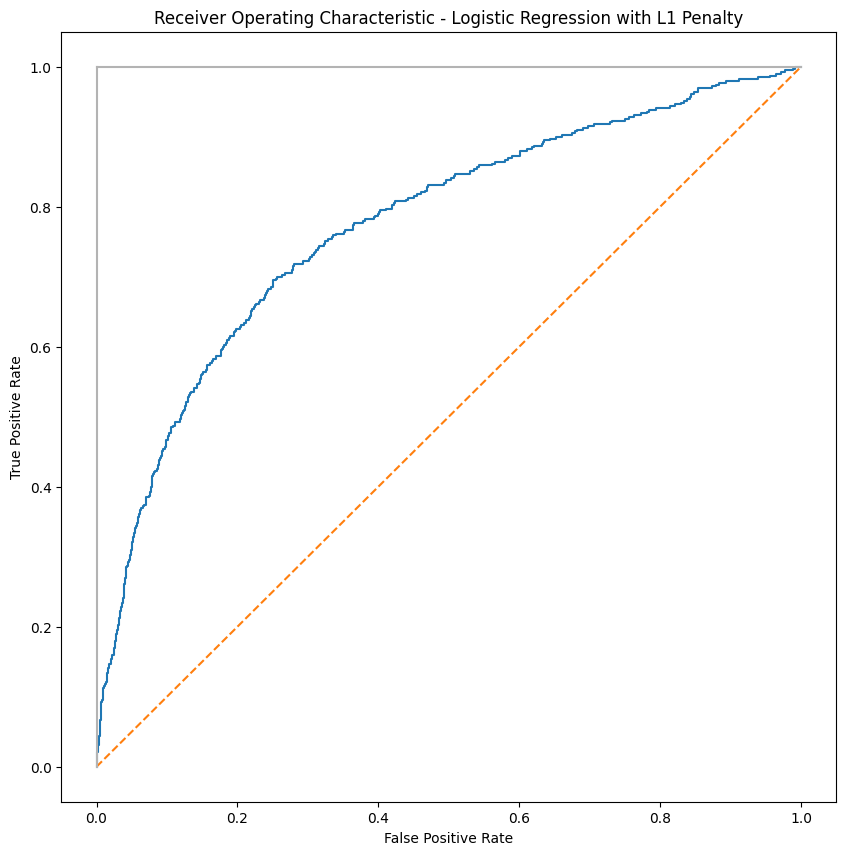

In [85]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Logistic Regression with L1 Penalty')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Logistic Regression with L2 penalty

In [ ]:
# Perfrom grid search for hyperparameter selection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the logistic regression model
lr = LogisticRegression(penalty='l2')

# Define the hyperparameters to be tuned
params = {
    'C': [0.1, 1.0, 10.0],
    'random_state' : [10, 20, 30],
    'max_iter' : [5000, 6000, 6500],
    'solver': ['sag']
}

# Perform a grid search with cross-validation
grid_search = GridSearchCV(lr, params, cv=5)
grid_search.fit(x, y)

# Print the best hyperparameters and score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

In [86]:
# Build the model
clf_L2 = LogisticRegression(C=5.0,
                          penalty='l2',
                          solver='sag',
                          max_iter=6000,
                          class_weight='balanced'
                          ).fit(x, y)

# Test the performance of the model
y_test_L2 = clf_L2.predict(x_test)
ar,num=np.unique(y_test_L2,return_counts=True)
print(ar,num)
print("The accuracy score for this model is ", (y_test==y_test_L2).sum()/len(y_test))

[0. 1.] [6536 3568]
The accuracy score for this model is  0.6559778305621536


g:\anaconda3\envs\easy_work\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [87]:
# Plotting ROC curve for the logistic regression model with L2 penalty
from sklearn.metrics import roc_curve, roc_auc_score
y_score_L2 = clf_L2.predict_proba(x_test)[:,1]
print(y_score_L2.shape)
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score_L2)
roc_L2 = roc_auc_score(y_test, y_score_L2)
print('roc_auc_score for logistic regression model with L2 penalty: ', roc_L2)

(10104,)
roc_auc_score for logistic regression model with L2 penalty:  0.6982486287304076


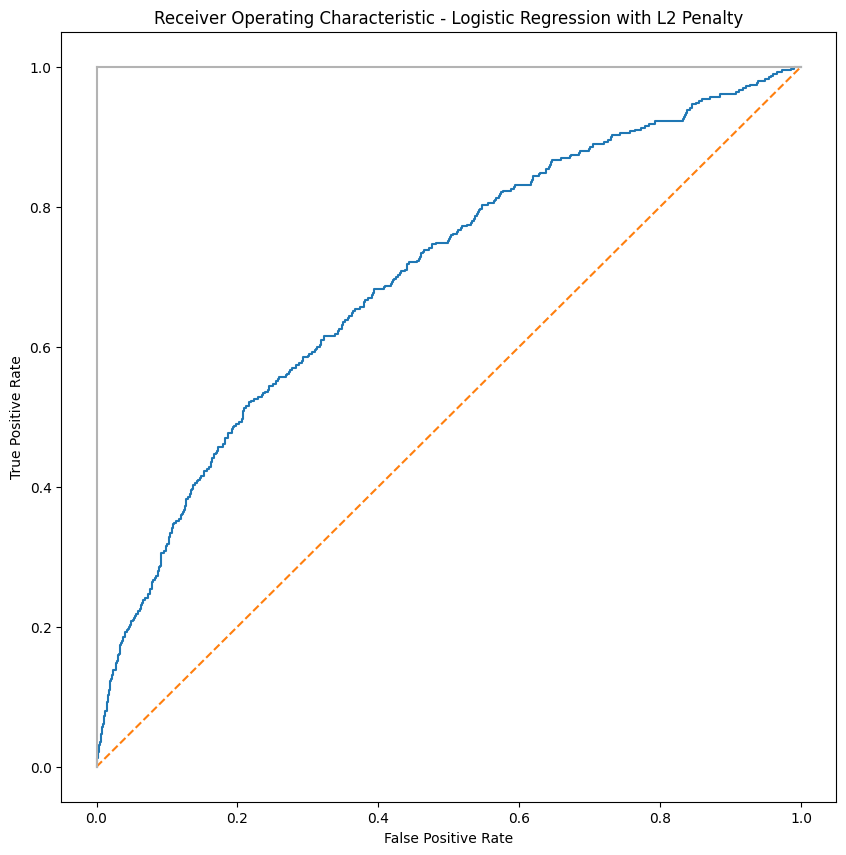

In [88]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Logistic Regression with L2 Penalty')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Elastic Net Regression

In [ ]:
# Pefrom grid search for hyperparameter selection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


# Define the logistic regression model with elastic net regularization
lr = LogisticRegression(penalty='elasticnet', solver='saga')

# Define the hyperparameters to be tuned
params = {
    'C': [0.01, 0.1, 1, 10],
    'l1_ratio': [0.3, 0.5, 0.7],
    'random_state' : [10, 20, 30],
    'n_jobs' : [-1,-2,-3]
}

# Perform a grid search with cross-validation
grid_search = GridSearchCV(lr, params, cv=5)
grid_search.fit(x, y)

# Print the best hyperparameters and score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)


In [89]:
# Build the model
clf_elas = LogisticRegression(C=1.0,
                          penalty='elasticnet',
                          solver='saga',
                          l1_ratio=0.3,
                          max_iter=5000,
                          class_weight='balanced'
                          ).fit(x, y)

# Test the performance of the model
y_test_elas = clf_elas.predict(x_test)
ar,num=np.unique(y_test_elas,return_counts=True)
print(ar,num)
print("The accuracy score for this model is ", (y_test==y_test_elas).sum()/len(y_test))

[0. 1.] [6221 3883]
The accuracy score for this model is  0.6224267616785432


g:\anaconda3\envs\easy_work\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [90]:
# Plotting ROC curve for the logistic regression model with Elastic Net penalty
from sklearn.metrics import roc_curve, roc_auc_score
y_score_elas = clf_elas.predict_proba(x_test)[:,1]
print(y_score_elas.shape)
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score_elas)
roc_elas = roc_auc_score(y_test, y_score_elas)
print('roc_auc_score for logistic regression model with elastic net penalty: ', roc_elas)


(10104,)
roc_auc_score for logistic regression model with elastic net penalty:  0.650748853095981


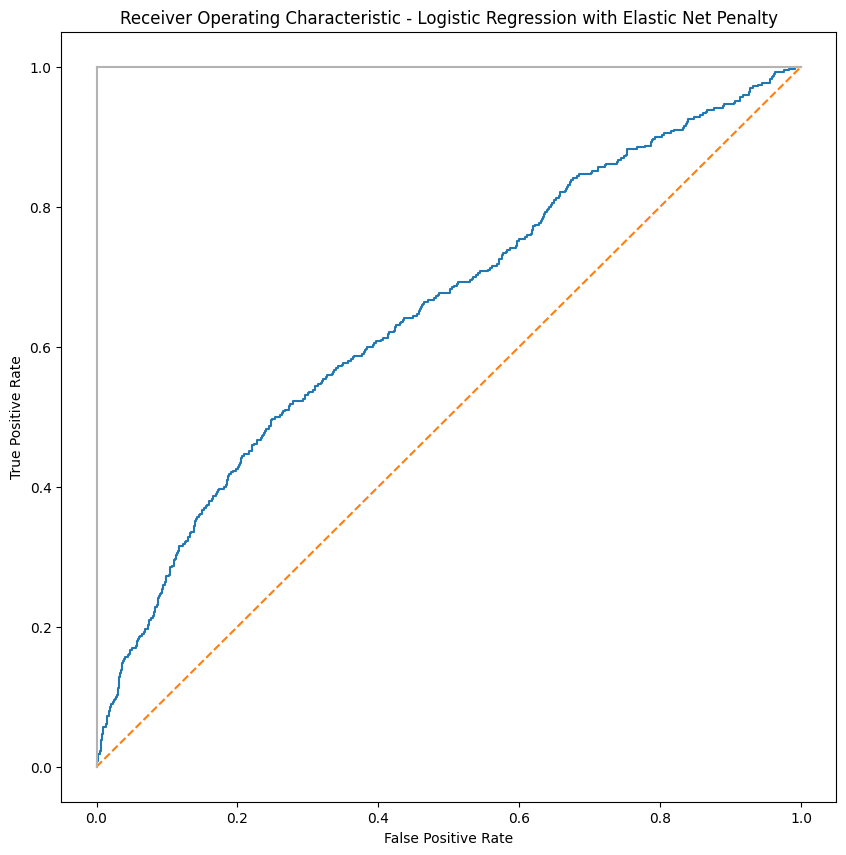

In [91]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Logistic Regression with Elastic Net Penalty')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Model Comparison

In [92]:
# Create confusion matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Get confusion matrices for each model
cm_tree = confusion_matrix(y_test, y_test_tree)
cm_rfc = confusion_matrix(y_test, y_test_rfc)
cm_ada = confusion_matrix(y_test, y_test_ada)
cm_svm = confusion_matrix(y_test, y_test_svm)
cm_L1 = confusion_matrix(y_test, y_test_L1)
cm_L2 = confusion_matrix(y_test, y_test_L2)
cm_elas = confusion_matrix(y_test, y_test_elas)

# Visualize the confusion matrices
print("Confusion Matrix for decision tree:")
print(cm_tree)
print("\nConfusion Matrix for random forest:")
print(cm_rfc)
print("\nConfusion Matrix for adaboost:")
print(cm_ada)
print("\nConfusion Matrix for SVM:")
print(cm_svm)
print("\nConfusion Matrix for logistic regression with L1 penalty:")
print(cm_L1)
print("\nConfusion Matrix for logistic regression with L2 penalty:")
print(cm_L2)
print("\nConfusion Matrix for logistic regression with elastic net penalty:")
print(cm_elas)

Confusion Matrix for decision tree:
[[9707    7]
 [ 385    5]]

Confusion Matrix for random forest:
[[9691   23]
 [ 382    8]]

Confusion Matrix for adaboost:
[[9714    0]
 [ 388    2]]

Confusion Matrix for SVM:
[[5609 4105]
 [ 183  207]]

Confusion Matrix for logistic regression with L1 penalty:
[[7485 2229]
 [ 132  258]]

Confusion Matrix for logistic regression with L2 penalty:
[[6387 3327]
 [ 149  241]]

Confusion Matrix for logistic regression with elastic net penalty:
[[6060 3654]
 [ 161  229]]


In [93]:
# Make a dataframe including all evaluation metrics
# First calculate the metrics for each model
acc_tree = accuracy_score(y_test, y_test_tree)
prec_tree = precision_score(y_test, y_test_tree)
rec_tree = recall_score(y_test, y_test_tree)
f1_tree = f1_score(y_test, y_test_tree)

acc_rfc = accuracy_score(y_test, y_test_rfc)
prec_rfc = precision_score(y_test, y_test_rfc)
rec_rfc = recall_score(y_test, y_test_rfc)
f1_rfc= f1_score(y_test, y_test_rfc)

acc_ada = accuracy_score(y_test, y_test_ada)
prec_ada= precision_score(y_test, y_test_ada)
rec_ada = recall_score(y_test, y_test_ada)
f1_ada= f1_score(y_test, y_test_ada)

acc_svm = accuracy_score(y_test, y_test_svm)
prec_svm = precision_score(y_test, y_test_svm)
rec_svm = recall_score(y_test, y_test_svm)
f1_svm= f1_score(y_test, y_test_svm)

acc_L1 = accuracy_score(y_test, y_test_L1)
prec_L1 = precision_score(y_test, y_test_L1)
rec_L1 = recall_score(y_test, y_test_L1)
f1_L1= f1_score(y_test, y_test_L1)

acc_L2 = accuracy_score(y_test, y_test_L2)
prec_L2 = precision_score(y_test, y_test_L2)
rec_L2 = recall_score(y_test, y_test_L2)
f1_L2= f1_score(y_test, y_test_L2)

acc_elas = accuracy_score(y_test, y_test_elas)
prec_elas = precision_score(y_test, y_test_elas)
rec_elas = recall_score(y_test, y_test_elas)
f1_elas= f1_score(y_test, y_test_elas)

# Create a dictionary to store the metrics for each model
Dict = {
    'Model': ['Decision Tree', 'Random Forest', 'Adaboost', 'SVM', 'LR with L1', 'LR with L2', 'LR with Elastic Net'],
    'Accuracy': [acc_tree, acc_rfc, acc_ada, acc_svm, acc_L1, acc_L2, acc_elas],
    'Precision': [prec_tree, prec_rfc, prec_ada, prec_svm, prec_L1, prec_L2, prec_elas],
    'Recall': [rec_tree, rec_rfc, rec_ada, rec_svm, rec_L1, rec_L2, rec_elas],
    'F1 Score': [f1_tree, f1_rfc, f1_ada, f1_svm, f1_L1, f1_L2, f1_elas],
    'ROC Score': [roc_tree,roc_rfc, roc_ada, roc_svm, roc_L1, roc_L2, roc_elas]
    }

metrics_df = pd.DataFrame(Dict)
metrics_df.set_index('Model', inplace=True)
print(metrics_df)

                     Accuracy  Precision    Recall  F1 Score  ROC Score
Model                                                                  
Decision Tree        0.961203   0.416667  0.012821  0.024876   0.759462
Random Forest        0.959917   0.258065  0.020513  0.038005   0.655606
Adaboost             0.961599   1.000000  0.005128  0.010204   0.760941
SVM                  0.575614   0.048006  0.530769  0.088048   0.586744
LR with L1           0.766330   0.103739  0.661538  0.179353   0.772364
LR with L2           0.655978   0.067545  0.617949  0.121779   0.698249
LR with Elastic Net  0.622427   0.058975  0.587179  0.107185   0.650749
